In [1]:
from MHC_classifier import MHClassifier
from MHC_classifier import LightningDataModule,LightningModel,DataPlanner,TensorBoardLogger
from pytorch_lightning import Trainer
import torch

In [65]:
# Importing necessary libraries 

import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 300

In [3]:
# Importing the input data for the model
# fold_test : Consists of test data (test.csv) 
# HLA embeddings : This file consists the embeddings of HLA proteins
fold_test = pd.read_csv("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/data/fold_test.csv") 
HLA_embeddings = pd.read_csv("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/data/HLA_embeddings.csv")

In [4]:
# Modify the data format from string of arrays into list of arrays

HLA_embeddings["protein_embed"] = [np.array(list(eval(s))) for s in HLA_embeddings["protein_embed"]]

In [5]:
# Assign each HLA proteins in the train and test data with its corresponding embeddings (embeddings size:1024)
test_data = fold_test.merge(HLA_embeddings,left_on="allele",right_on="allele")

In [6]:
# define the function to encode the peptide sequence using one hot encoding

def one_hot_encoding(sequence):
    # Define the mapping of amino acids to indices
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

    # Initialize the one-hot encoded array
    num_amino_acids = len(amino_acids)
    encoding = np.zeros((len(sequence), num_amino_acids))

    # Encode each amino acid in the sequence
    for i, aa in enumerate(sequence):
        if aa in aa_to_index:
            index = aa_to_index[aa]
            encoding[i][index] = 1
        else:
            # Handle unknown amino acids (e.g., 'X')
            encoding[i][-1] = 1

    return encoding.ravel()

In [10]:

fold_test = test_data[test_data["data"] == "fold_test"]
fold_test['peptide_input'] = fold_test['clean_peptide'].apply(one_hot_encoding)

X1_test = fold_test['peptide_input']
X2_test = fold_test['protein_embed']
y_test = fold_test['hit']

In [12]:
# convert the list into array
X1_test = np.array(X1_test.tolist())
X2_test = np.array(X2_test.tolist())
y_test = np.array(y_test.tolist())

In [13]:
# Define hidden layers and input data sizes
peptide_input = 180  # Length of peptide sequence 8 * 20 = 160 
protein_input = 1024  # Dimension of categorical variable defining protein sequence
peptide_hideen_layers = [90,18]  # Hidden layers for peptide network 
protein_hideen_layers = [512,18]  # Hidden layers for protein network 
peptide_protein_hideen_layers = [36,1] # Hidden layers size for protein-peptide concatenated network
output_size = 1  # Output size
batch_size = 1000 # batch size 
workers = 10 # number of cpu/gpu cores

# Create model instance
model = MHClassifier(peptide_input, protein_input, peptide_hideen_layers, protein_hideen_layers,peptide_protein_hideen_layers, output_size)

# Create Lightning model
lightning_model = LightningModel(model)

In [14]:
lightning_model.model.load_state_dict(torch.load("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/notebooks/models/Training_model_0.pl"))
lightning_model.model.eval()

MHClassifier(
  (layers_peptide): Sequential(
    (0): Sequential(
      (0): Linear(in_features=180, out_features=90, bias=False)
      (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=90, out_features=18, bias=False)
      (1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (layers_protein): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=18, bias=False)
    )
  )
  (peptide_protein_concat): Linear(in_features=36, out_features=36, bias=True)
  (Combined_Peptide_protein_layer): Sequential(
    (0): Sequential(
      (0): Linear(in_features=36, out_features=36, bias=False)
      (1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
  

In [15]:
#AUC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=14)
    plt.legend(loc='lower right')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)    
    plt.show()
    return auc_score

In [ ]:
# Converting predicted data from tensor to numpy and create dataframe for target values, predicted values and predicted probability
y_predict = y_predict.cpu().detach().numpy()
y_predict = np.array(y_predict.ravel())
Prediction = pd.DataFrame({'Target':y_test, 'Predicted_probability':y_predict})

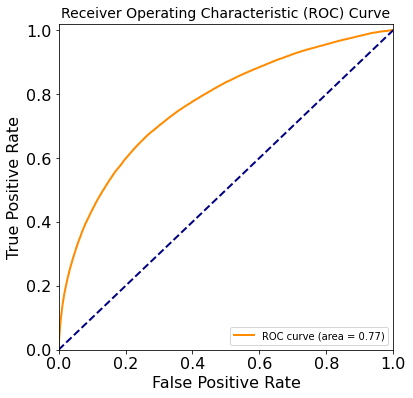

0.7681592212994921

In [17]:

# Create Lightning model
lightning_model = LightningModel(model)
lightning_model.model.load_state_dict(torch.load("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/notebooks/models/Training_model_0.pl"))
lightning_model.model.eval()
# model prediction over 20% test data
y_predict = lightning_model.predict(torch.tensor(X1_test,dtype=torch.float),torch.tensor(X2_test,dtype=torch.float))
# Converting predicted data from tensor to numpy and create dataframe for target values, predicted values and predicted probability
y_predict = y_predict.cpu().detach().numpy()
y_predict = np.array(y_predict.ravel())
Prediction = pd.DataFrame({'Target':y_test, 'Predicted_probability':y_predict})
Prediction["Predicted_probability"] = y_predict
Prediction['Predicted'] =  np.where(Prediction['Predicted_probability']>0.5,1, 0)
plot_roc_curve(Prediction["Target"],Prediction["Predicted_probability"])

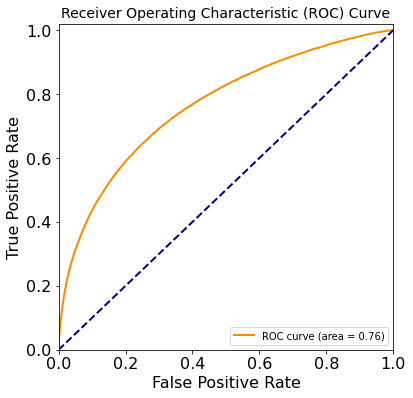

0.7628831972730286

In [18]:
# Create Lightning model
lightning_model_1 = LightningModel(model)
lightning_model_1.model.load_state_dict(torch.load("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/notebooks/models/Training_model_1.pl"))
lightning_model_1.model.eval()
# model prediction over 20% test data
y_predict = lightning_model.predict(torch.tensor(X1_test,dtype=torch.float),torch.tensor(X2_test,dtype=torch.float))
# Converting predicted data from tensor to numpy and create dataframe for target values, predicted values and predicted probability
y_predict = y_predict.cpu().detach().numpy()
y_predict = np.array(y_predict.ravel())
Prediction["Predicted_probability_1"] = y_predict
Prediction['Predicted_1'] =  np.where(Prediction['Predicted_probability_1']>0.5,1, 0)
accuracy_score(Prediction["Target"], Prediction["Predicted_1"])
plot_roc_curve(Prediction["Target"],Prediction["Predicted_probability_1"])

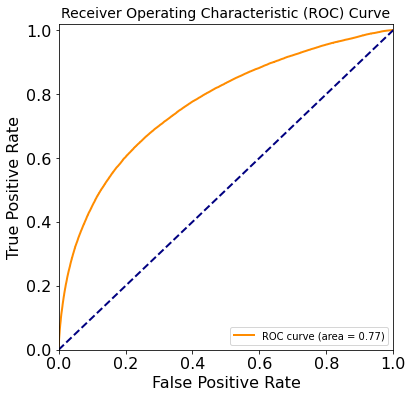

0.7691504123004704

In [19]:
# Create Lightning model
lightning_model_2 = LightningModel(model)
lightning_model_2.model.load_state_dict(torch.load("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/notebooks/models/Training_model_2.pl"))
lightning_model_2.model.eval()
# model prediction over 20% test data
y_predict = lightning_model.predict(torch.tensor(X1_test,dtype=torch.float),torch.tensor(X2_test,dtype=torch.float))
# Converting predicted data from tensor to numpy and create dataframe for target values, predicted values and predicted probability
y_predict = y_predict.cpu().detach().numpy()
y_predict = np.array(y_predict.ravel())
Prediction["Predicted_probability_2"] = y_predict
Prediction['Predicted_2'] =  np.where(Prediction['Predicted_probability_2']>0.5,1, 0)
accuracy_score(Prediction["Target"], Prediction["Predicted_2"])
plot_roc_curve(Prediction["Target"],Prediction["Predicted_probability_2"])


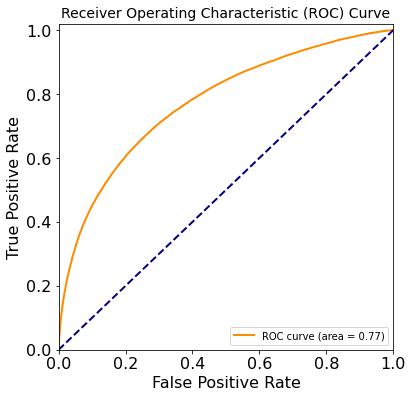

0.7734100434590608

In [21]:
# Create Lightning model
lightning_model_3 = LightningModel(model)
lightning_model_3.model.load_state_dict(torch.load("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/notebooks/models/Training_model_3.pl"))
lightning_model_3.model.eval()
# model prediction over 20% test data
y_predict = lightning_model.predict(torch.tensor(X1_test,dtype=torch.float),torch.tensor(X2_test,dtype=torch.float))
# Converting predicted data from tensor to numpy and create dataframe for target values, predicted values and predicted probability
y_predict = y_predict.cpu().detach().numpy()
y_predict = np.array(y_predict.ravel())
Prediction["Predicted_probability_3"] = y_predict
Prediction['Predicted_3'] =  np.where(Prediction['Predicted_probability_3']>0.5,1, 0)
plot_roc_curve(Prediction["Target"],Prediction["Predicted_probability_3"])

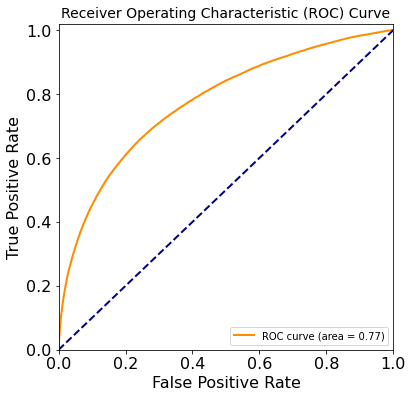

0.7737951281079317

In [22]:
# Create Lightning model
lightning_model_4 = LightningModel(model)
lightning_model_4.model.load_state_dict(torch.load("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/notebooks/models/Training_model_4.pl"))
lightning_model_4.model.eval()
# model prediction over 20% test data
y_predict = lightning_model.predict(torch.tensor(X1_test,dtype=torch.float),torch.tensor(X2_test,dtype=torch.float))
# Converting predicted data from tensor to numpy and create dataframe for target values, predicted values and predicted probability
y_predict = y_predict.cpu().detach().numpy()
y_predict = np.array(y_predict.ravel())
Prediction["Predicted_probability_4"] = y_predict
Prediction['Predicted_4'] =  np.where(Prediction['Predicted_probability_4']>0.5,1, 0)
plot_roc_curve(Prediction["Target"],Prediction["Predicted_probability_4"])

In [23]:
Prediction

,Target,Predicted_probability,Predicted,Predicted_probability_1,Predicted_1,Predicted_probability_2,Predicted_2,Predicted_probability_3,Predicted_3,Predicted_probability_4,Predicted_4
0,1,0.717020,1,0.491229,0,0.898564,1,0.092631,0,0.454846,0
1,1,0.755325,1,0.983101,1,0.872250,1,0.858630,1,0.061062,0
2,1,0.207322,0,0.121785,0,0.044461,0,0.369950,0,0.817876,1
3,1,0.028758,0,0.385405,0,0.298726,0,0.011651,0,0.358695,0
4,1,0.061548,0,0.419312,0,0.098128,0,0.142568,0,0.025983,0
...,...,...,...,...,...,...,...,...,...,...,...
946136,0,0.006684,0,0.018958,0,0.013078,0,0.012404,0,0.024806,0
946137,0,0.003496,0,0.001417,0,0.018008,0,0.002700,0,0.000655,0
946138,0,0.001187,0,0.000568,0,0.000556,0,0.004664,0,0.023632,0
946139,0,0.831698,1,0.191598,0,0.054752,0,0.010641,0,0.086499,0


In [27]:
Prediction[["Predicted_probability","Predicted_probability_1","Predicted_probability_2","Predicted_probability_3","Predicted_probability_4"]]

,Predicted_probability,Predicted_probability_1,Predicted_probability_2,Predicted_probability_3,Predicted_probability_4
0,0.717020,0.491229,0.898564,0.092631,0.454846
1,0.755325,0.983101,0.872250,0.858630,0.061062
2,0.207322,0.121785,0.044461,0.369950,0.817876
3,0.028758,0.385405,0.298726,0.011651,0.358695
4,0.061548,0.419312,0.098128,0.142568,0.025983
...,...,...,...,...,...
946136,0.006684,0.018958,0.013078,0.012404,0.024806
946137,0.003496,0.001417,0.018008,0.002700,0.000655
946138,0.001187,0.000568,0.000556,0.004664,0.023632
946139,0.831698,0.191598,0.054752,0.010641,0.086499


In [39]:
def process_probabilities(df):
    # Define a function to apply row-wise
    def process_row(row):
        # Check if any value in the row is greater than 0.9
        if (row > 0.8).any():
            # If so, return the maximum value
            return row.max()
        else:
            # Otherwise, return the mean of all values
            return row.mean()

    # Apply the function to each row and assign the result to a new row
    df['ensemble_probability'] = df.apply(process_row, axis=1)
    
    return df


In [40]:
df_probabilities = process_probabilities(Prediction[["Predicted_probability","Predicted_probability_1","Predicted_probability_2","Predicted_probability_3","Predicted_probability_4"]])

/tmp/ipykernel_4787/4219101865.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ensemble_probability'] = df.apply(process_row, axis=1)


In [42]:
Prediction["Ensemble_probability"] = df_probabilities["ensemble_probability"]

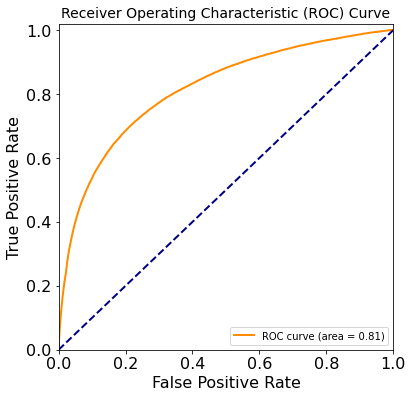

0.8137090416830124

In [43]:
plot_roc_curve(Prediction["Target"],Prediction["Ensemble_probability"])

In [45]:
Prediction['Predicted_ensemble'] =  np.where(Prediction['Ensemble_probability']>0.5,1, 0)


In [46]:
accuracy_score(Prediction["Target"], Prediction["Predicted_ensemble"])

0.9421217344983465

In [50]:
df_probabilities

,Predicted_probability,Predicted_probability_1,Predicted_probability_2,Predicted_probability_3,Predicted_probability_4,ensemble_probability
0,0.717020,0.491229,0.898564,0.092631,0.454846,0.898564
1,0.755325,0.983101,0.872250,0.858630,0.061062,0.983101
2,0.207322,0.121785,0.044461,0.369950,0.817876,0.817876
3,0.028758,0.385405,0.298726,0.011651,0.358695,0.216647
4,0.061548,0.419312,0.098128,0.142568,0.025983,0.149508
...,...,...,...,...,...,...
946136,0.006684,0.018958,0.013078,0.012404,0.024806,0.015186
946137,0.003496,0.001417,0.018008,0.002700,0.000655,0.005255
946138,0.001187,0.000568,0.000556,0.004664,0.023632,0.006121
946139,0.831698,0.191598,0.054752,0.010641,0.086499,0.831698


In [63]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(df):
    # Initialize the plot
    plt.figure(figsize=(8, 6))
    
    # Define line styles for different models
    line_styles = ['-', '--', '-.', ':', '-', '--']
    
    # Iterate over each model's probabilities
    for i, model_name in enumerate(([ 'Predicted_probability','Predicted_probability_1', 'Predicted_probability_2', 'Predicted_probability_3','Predicted_probability_4', 'Ensemble_probability'])):
        # Compute ROC curve and AUC for each model
        fpr, tpr, _ = roc_curve(df['Target'], df[model_name])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, linestyle=line_styles[i], label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # Plot the diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
    
    # Set plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    
    # Add legend
    plt.legend(loc='lower right')
    
    # Show the plot
    plt.show()


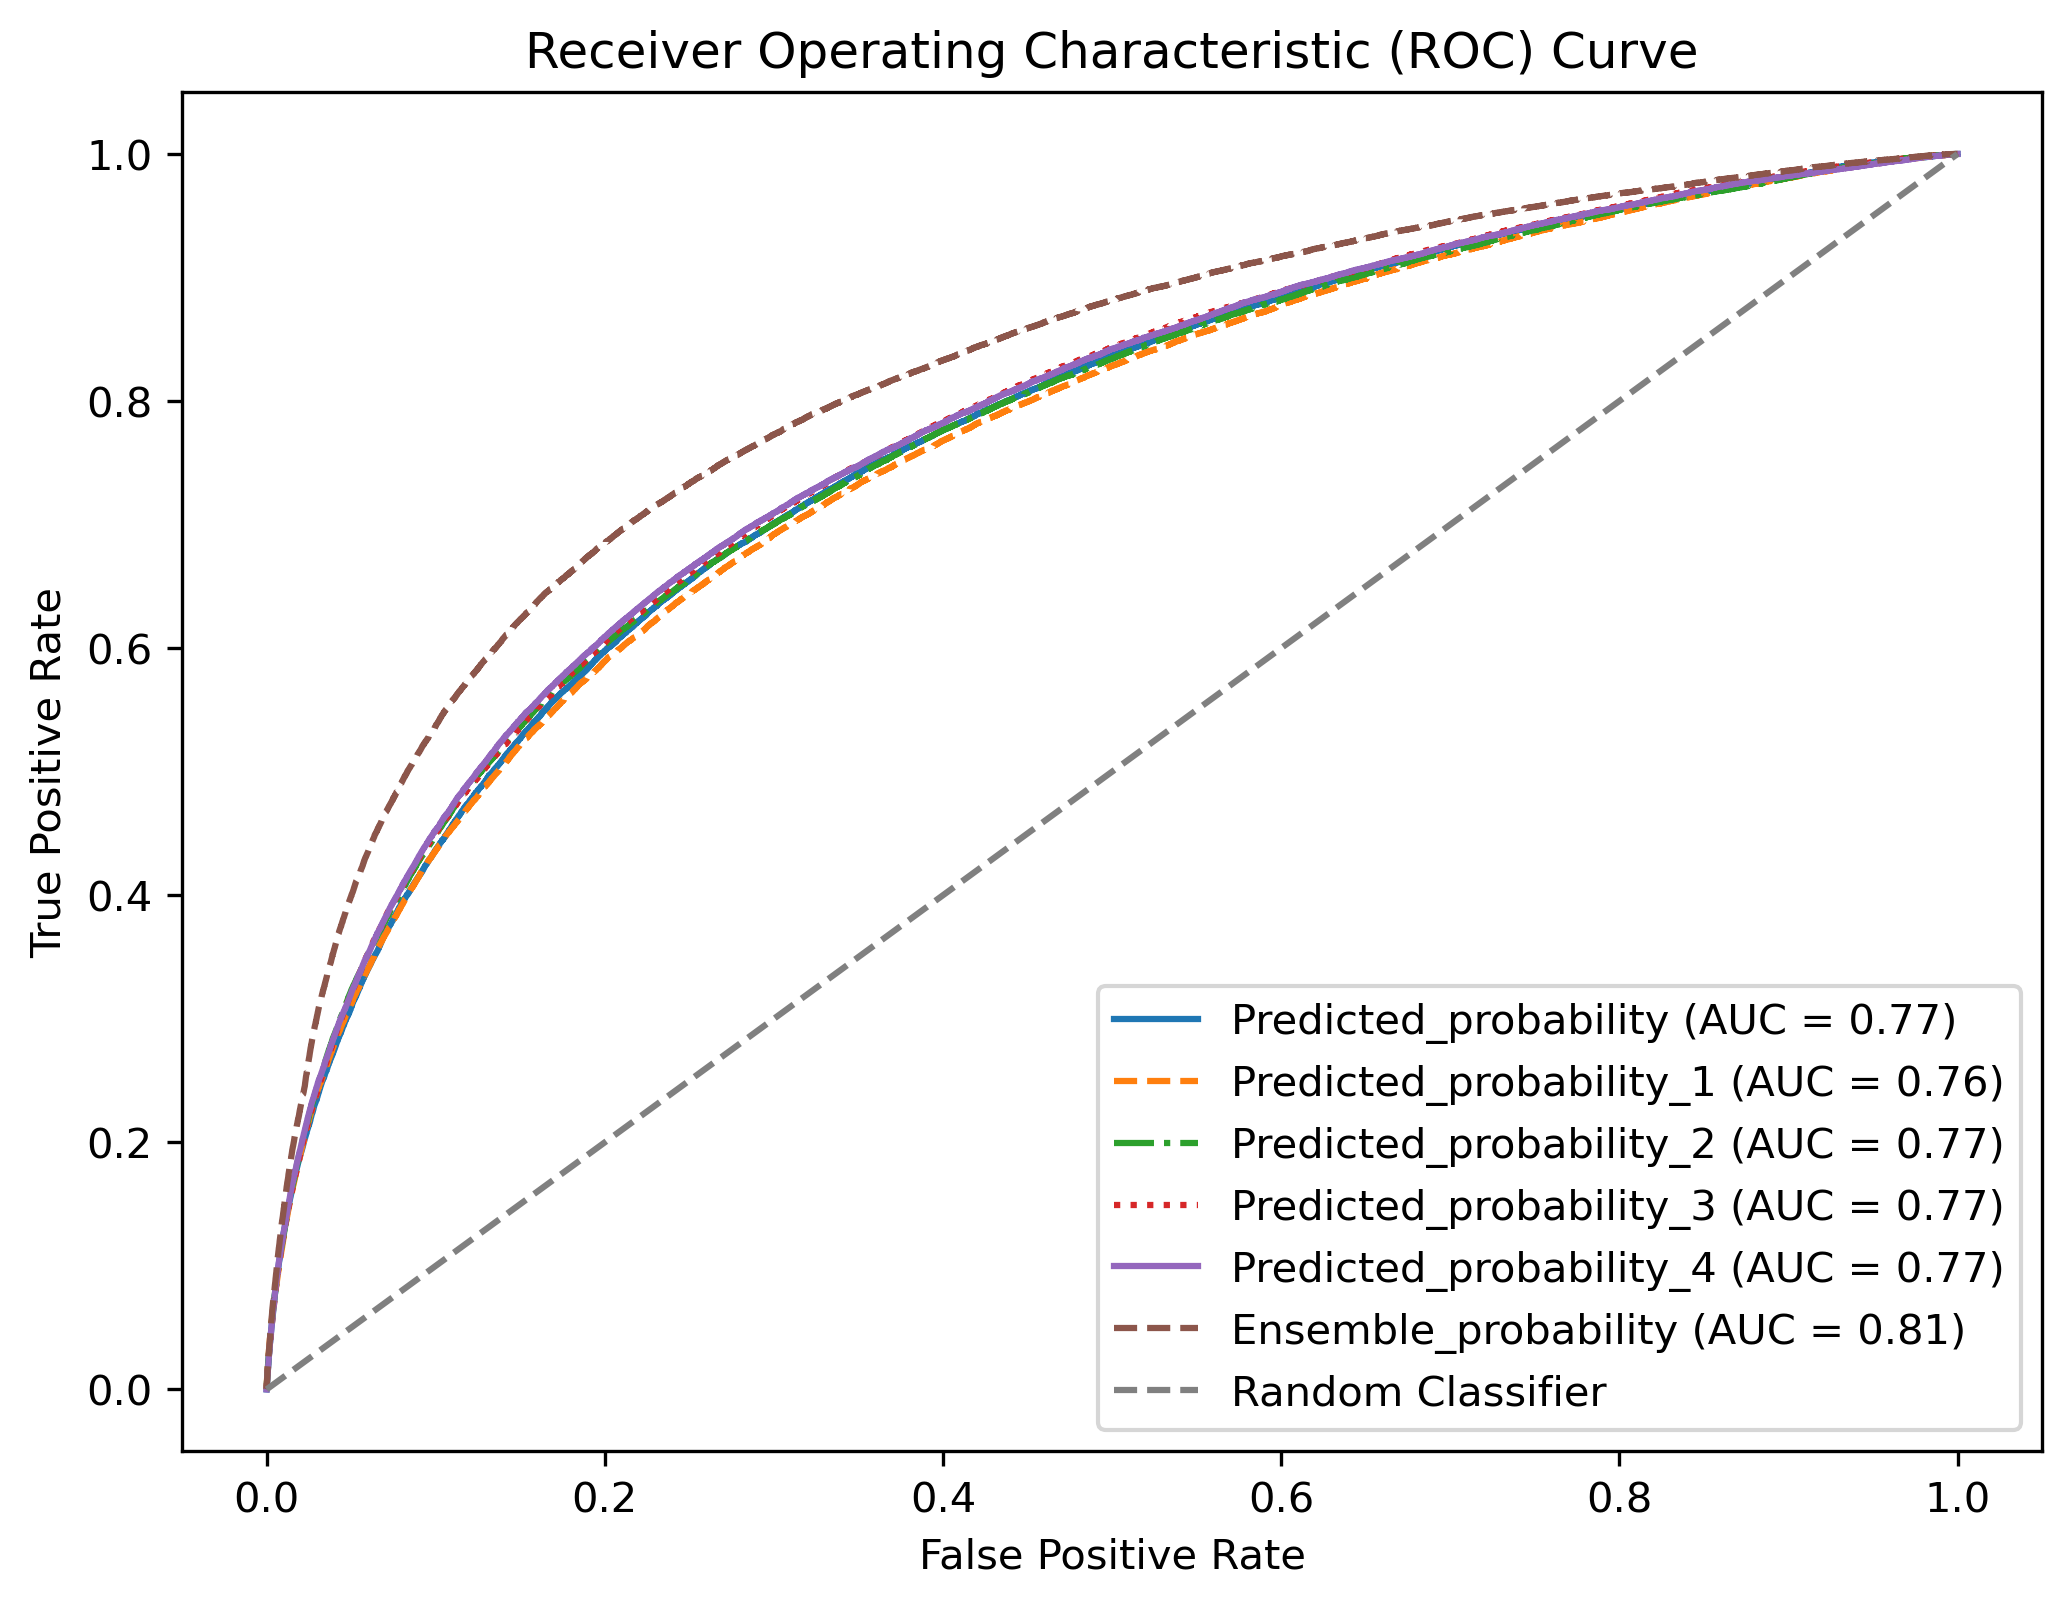

In [66]:
plot_roc_curves(Prediction)

<AxesSubplot:xlabel='Target', ylabel='Count'>

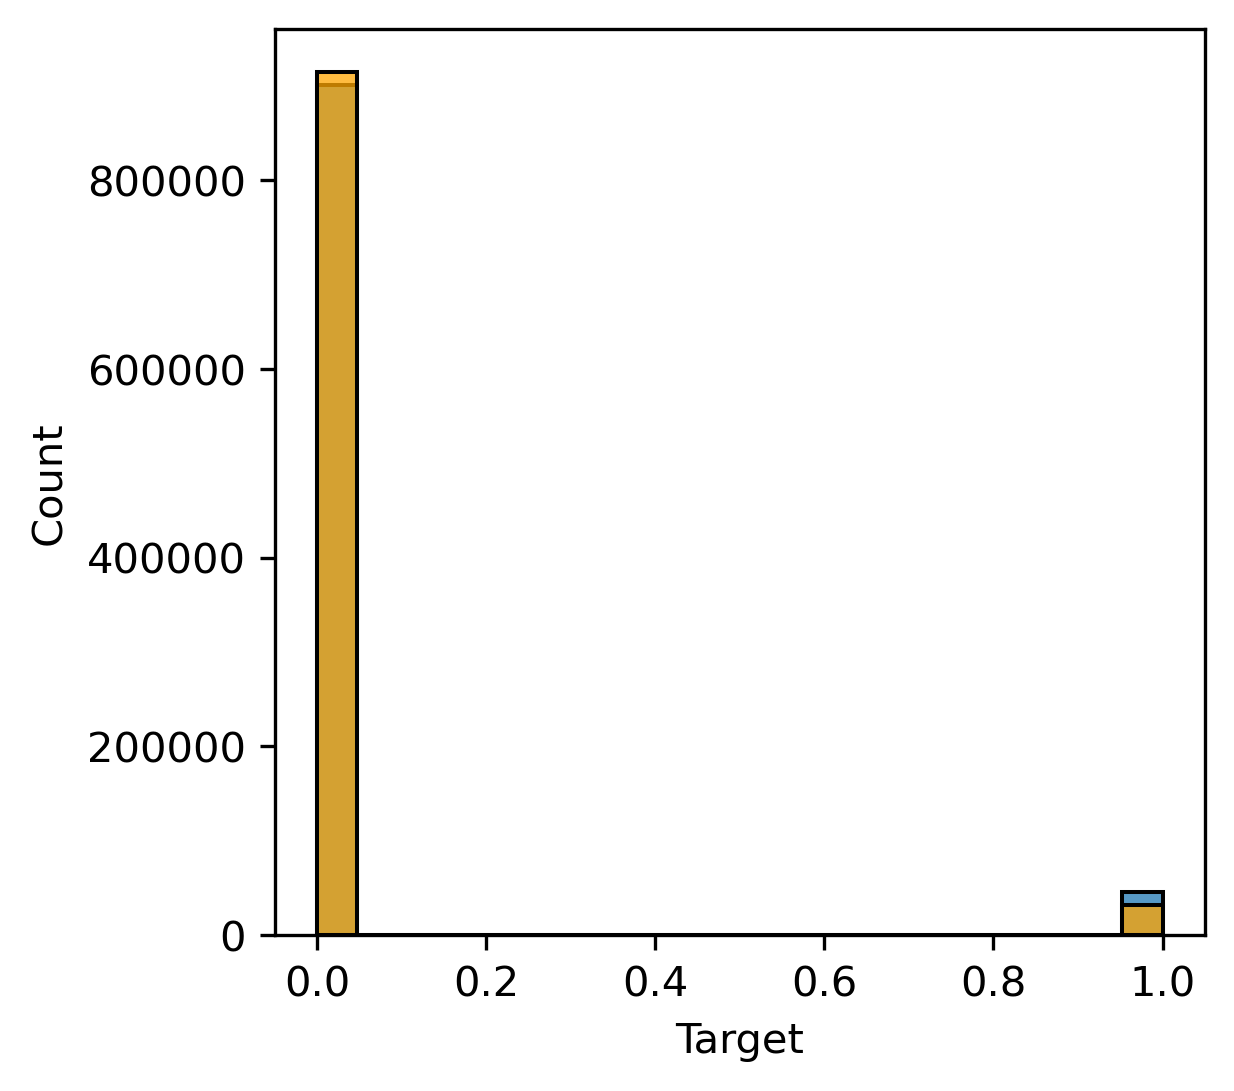

In [67]:
sns.histplot(data=Prediction, x="Target")
sns.histplot(data=Prediction, x="Predicted_ensemble",color='orange')

In [70]:
print(accuracy_score(Prediction["Target"], Prediction["Predicted_ensemble"]))
print(accuracy_score(Prediction["Target"], Prediction["Predicted"]))
print(accuracy_score(Prediction["Target"], Prediction["Predicted_1"]))
print(accuracy_score(Prediction["Target"], Prediction["Predicted_2"]))
print(accuracy_score(Prediction["Target"], Prediction["Predicted_3"]))
print(accuracy_score(Prediction["Target"], Prediction["Predicted_4"]))


0.9421217344983465
0.9469000920581605
0.9440463947762543
0.9430444299528294
0.9374099632084436
0.9448094945679344
